In [1]:
import torch
from src.dataset import get_dataloaders
from src.utils import evaluate, set_random_seed, plot_confusion_matrix

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
set_random_seed()
_, test_loader, class_names = get_dataloaders("./data/Places2_simp")

In [3]:
import gdown

models = {
    "vit_70": {
        "link": "https://drive.google.com/file/d/1nBl246KJDEWDpOTjnfvSm2c-zZ_YnB-d/view?usp=drive_link",
        "output": "vit.pth"
    },
    "swin_66": {
        "link": "https://drive.google.com/file/d/106UL379Gkv292QbZzT1sBZpFi1IeVwyy/view?usp=drive_link",
        "output": "swin.pth"
    },
    "dinov2_80": {
        "link": "https://drive.google.com/file/d/1RBS8Bq8V3fuY3lGMxdA6S0xP-7Lq0NcY/view?usp=drive_link",
        "output": "dino.pth"
    }
}

for model in models.keys():
    trained_model = models.get(model)
    gdown.download(url=trained_model.get("link"), output=trained_model.get("output"), fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1nBl246KJDEWDpOTjnfvSm2c-zZ_YnB-d
From (redirected): https://drive.google.com/uc?id=1nBl246KJDEWDpOTjnfvSm2c-zZ_YnB-d&confirm=t&uuid=b7f2c25a-e55d-49fa-bcba-bca55d8e07d2
To: /user/HS400/rh01555/cwaml/scene-recognition-vit/vit.pth
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 343M/343M [00:03<00:00, 108MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=106UL379Gkv292QbZzT1sBZpFi1IeVwyy
From (redirected): https://drive.google.com/uc?id=106UL379Gkv292QbZzT1sBZpFi1IeVwyy&confirm=t&uuid=2528e404-9f51-4d2e-b336-ea48f5378906
To: /user/HS400/rh01555/cwaml/scene-recognition-vit/swin.pth
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 111M/111M [00:01<00:00, 104MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1RBS8Bq8V3fuY3lGMxdA6S0xP-7Lq0Nc

In [4]:
from src.models import load_vit_model

model_path = "/user/HS400/rh01555/cwaml/scene-recognition-vit/logs/log_rh01555_20250511_173706/dinov2_classifier.pth"
model = load_vit_model("dinov2").to("cuda")

state_dict = torch.load(model_path)
# Remove _orig_mod. from all keys since we are using torch.compile(model) while training
new_state_dict = {k.replace("_orig_mod.", ""): v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict)

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [5]:
print("Rank-1, Rank-5")
evaluate(model, test_loader, "cuda")

Rank-1, Rank-5


(80.8625, 97.575)

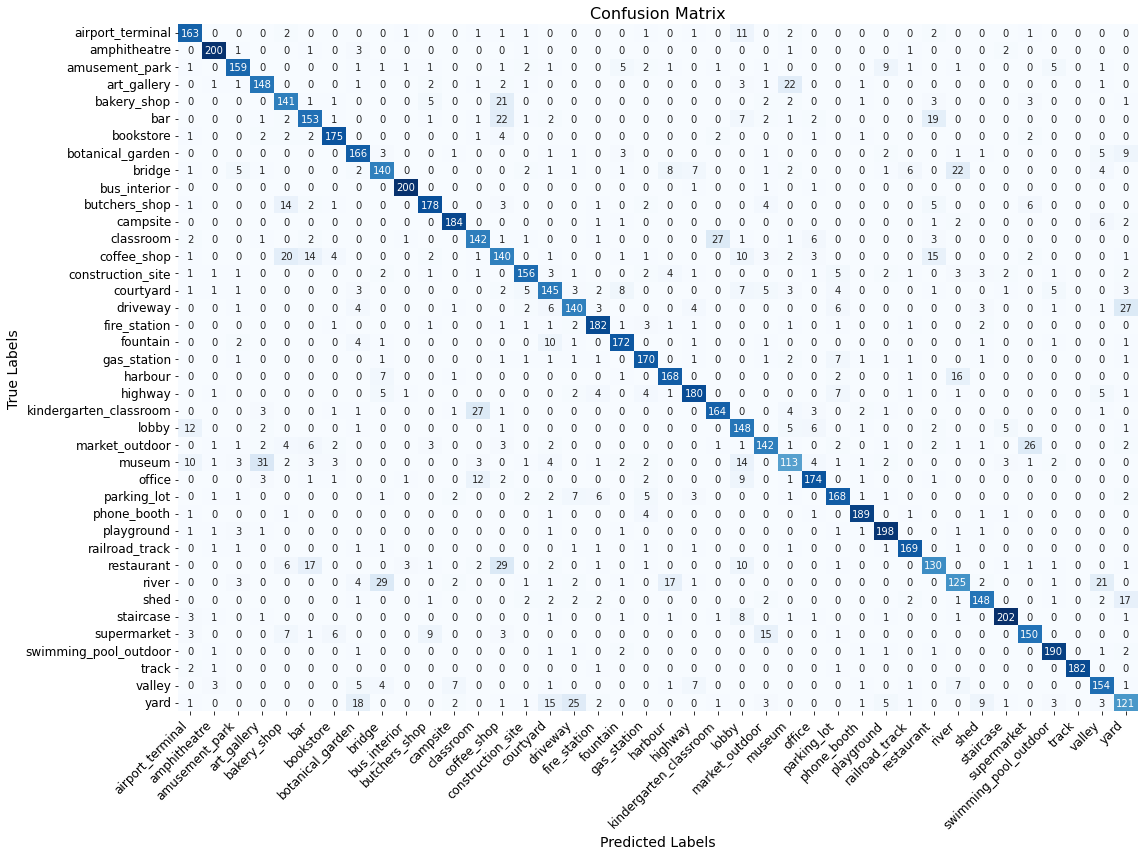

In [8]:
plot_confusion_matrix(model=model, dataloader=test_loader, class_names=class_names, device="cuda", save=False)

In [9]:
import torch
import matplotlib.pyplot as plt

def unnormalize(img_tensor):
    """Undo normalization for visualization."""
    mean = torch.tensor([0.4547, 0.4337, 0.4011]).view(3, 1, 1)
    std = torch.tensor([0.2266, 0.2237, 0.2316]).view(3, 1, 1)
    img = img_tensor * std + mean
    return torch.clamp(img, 0, 1)

def print_misclassified_grid(model, val_loader, class_names, device='cuda', max_to_show=12, cols=4):
    model.eval()
    model.to(device)
    misclassified_images = []
    titles = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images).logits
            preds = torch.argmax(outputs, dim=1)

            for img, label, pred in zip(images, labels, preds):
                if label != pred:
                    misclassified_images.append(unnormalize(img.cpu()))
                    titles.append(f"T: {class_names[label]}\nP: {class_names[pred]}")
                    if len(misclassified_images) >= max_to_show:
                        break
            if len(misclassified_images) >= max_to_show:
                break

    # Plot images in grid
    rows = (len(misclassified_images) + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axs = axs.flatten()

    for ax, img, title in zip(axs, misclassified_images, titles):
        ax.imshow(img.permute(1, 2, 0).numpy())
        ax.set_title(title, fontsize=9)
        ax.axis('off')

    # Turn off unused axes
    for i in range(len(misclassified_images), len(axs)):
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


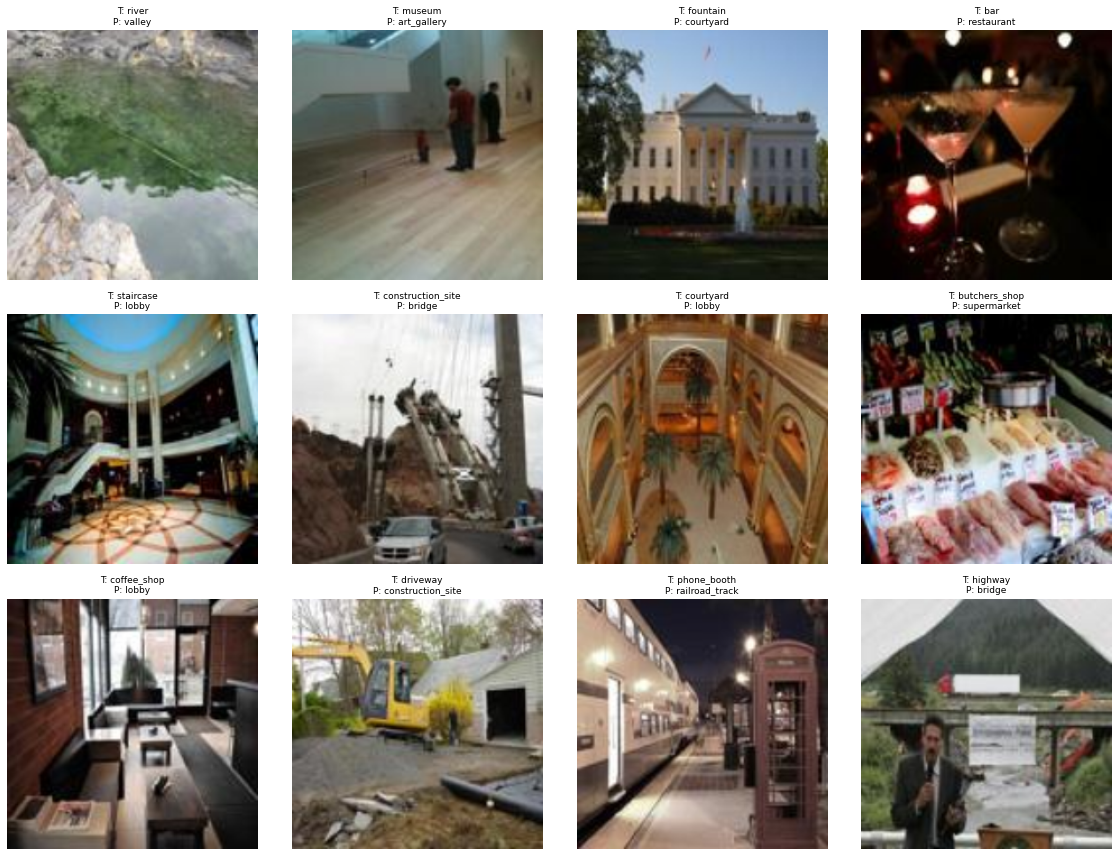

In [10]:
print_misclassified_grid(model, test_loader, class_names) # T = True Label, P = Predicted